In [1]:
import os
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
import cv2

In [2]:
train_images_path = "../data/train/images"
train_masks_path = "../data/train/masks"
test_images_path = "../data/test/images"
test_masks_path = "../data/test/masks"

num_train_images = len(os.listdir(train_images_path))
num_train_masks = len(os.listdir(train_masks_path))
num_test_images = len(os.listdir(test_images_path))
num_test_masks = len(os.listdir(test_masks_path))

print(f"Number of files in {train_images_path}:", num_train_images)
print(f"Number of files in {train_masks_path}:", num_train_masks)
print(f"Number of files in {test_images_path}:", num_test_images)
print(f"Number of files in {test_masks_path}:", num_test_masks)

Number of files in ../data/train/images: 2353
Number of files in ../data/train/masks: 2797
Number of files in ../data/test/images: 627
Number of files in ../data/test/masks: 688


In [3]:
train_images_filenames = list(os.listdir(train_images_path))
train_masks_filenames = list(os.listdir(train_masks_path))
test_images_filenames = list(os.listdir(test_images_path))
test_masks_filenames = list(os.listdir(test_masks_path))


def get_first_4_sections(filename):
    return "_".join(filename.split("_")[:4])


train_images_filenames_short = set(
    get_first_4_sections(filename) for filename in train_images_filenames
)
train_masks_filenames_short = set(
    get_first_4_sections(filename) for filename in train_masks_filenames
)
test_images_filenames_short = set(
    get_first_4_sections(filename) for filename in test_images_filenames
)
test_masks_filenames_short = set(
    get_first_4_sections(filename) for filename in test_masks_filenames
)

# Find filenames in masks but not in images
train_filenames_in_masks_not_in_images = (
    train_masks_filenames_short - train_images_filenames_short
)
train_filenames_in_images_not_in_masks = (
    train_images_filenames_short - train_masks_filenames_short
)
test_filenames_in_masks_not_in_images = (
    test_masks_filenames_short - test_images_filenames_short
)
test_filenames_in_images_not_in_masks = (
    test_images_filenames_short - test_masks_filenames_short
)

# Print some filenames
print(
    f"Filenames in train masks but not in train images: {len(train_filenames_in_masks_not_in_images)}"
)
print(
    f"Filenames in train images but not in train masks: {len(train_filenames_in_images_not_in_masks)}"
)
print(
    f"Filenames in test masks but not in test images: {len(test_filenames_in_masks_not_in_images)}"
)
print(
    f"Filenames in test images but not in test masks: {len(test_filenames_in_images_not_in_masks)}"
)

Filenames in train masks but not in train images: 0
Filenames in train images but not in train masks: 0
Filenames in test masks but not in test images: 0
Filenames in test images but not in test masks: 0


In [4]:
duplicated_train_filenames = list()
for filename in train_masks_filenames_short:
    count = sum(1 for f in train_masks_filenames if filename in f)
    if count > 1:
        duplicated_train_filenames.append(filename)
print(f"Duplicated filenames in masks: {len(duplicated_train_filenames)}")
duplicated_train_filenames.sort()

duplicated_test_filenames = list()
for filename in test_masks_filenames_short:
    count = sum(1 for f in test_masks_filenames if filename in f)
    if count > 1:
        duplicated_test_filenames.append(filename)
print(f"Duplicated filenames in masks: {len(duplicated_test_filenames)}")

Duplicated filenames in masks: 263
Duplicated filenames in masks: 52


In [5]:
masks_path = duplicated_train_filenames[0]
image_path = [f for f in train_images_filenames if f.startswith(masks_path)][0]

mask_paths = [
    os.path.join(train_masks_path, f) for f in train_masks_filenames if masks_path in f
]
mask_paths.sort()
print("Number of masks:", len(mask_paths))

Number of masks: 3


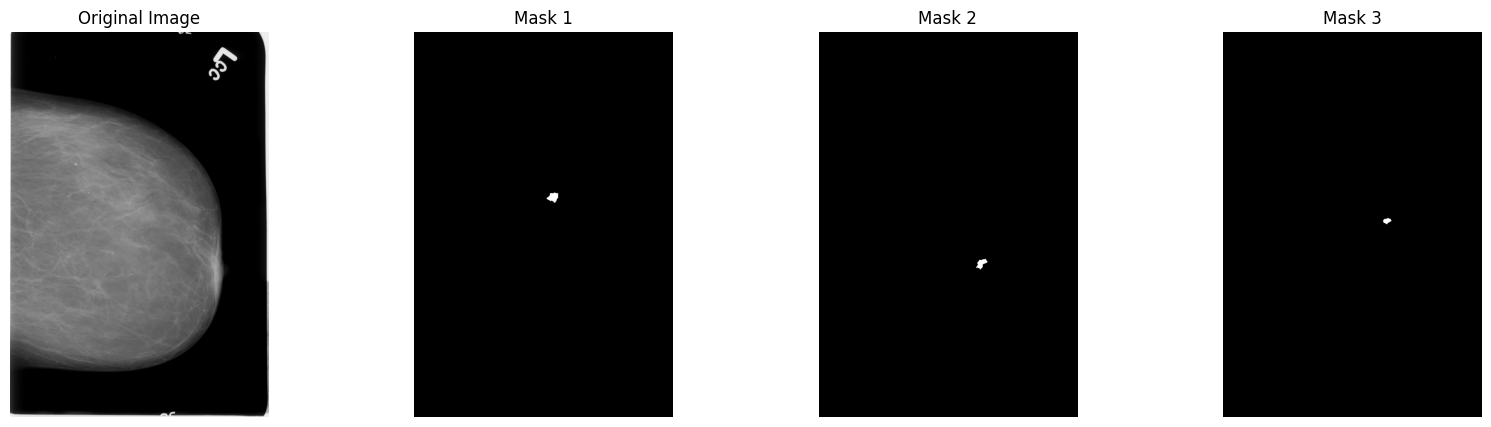

In [6]:
image = plt.imread(os.path.join(train_images_path, image_path))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")
for i, path in enumerate(mask_paths):
    masks = plt.imread(path)
    axes[i + 1].imshow(masks, cmap="gray")
    axes[i + 1].set_title(f"Mask {i+1}")
    axes[i + 1].axis("off")
plt.show()

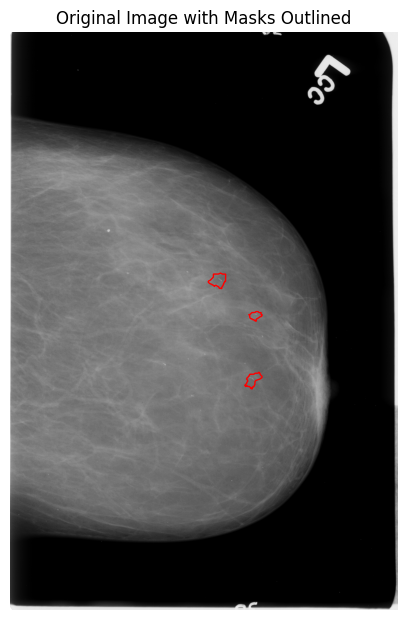

In [7]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(image, cmap="gray")
ax.set_title("Original Image with Masks Outlined")
ax.axis("off")

for path in mask_paths:
    mask = plt.imread(path)
    contours = measure.find_contours(mask, 0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")

plt.show()

In [8]:
image2_path = train_images_filenames[2]
image2 = plt.imread(os.path.join(train_images_path, image2_path))

print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")
print(f"Image mean value: {image.mean()}")
print()
print(f"Image2 shape: {image2.shape}")
print(f"Image2 min value: {image2.min()}")
print(f"Image2 max value: {image2.max()}")
print(f"Image2 mean value: {image2.mean()}")

Image shape: (4568, 3064)
Image min value: 0.0
Image max value: 1.0
Image mean value: 0.2410660684108734

Image2 shape: (4651, 2041)
Image2 min value: 0.0
Image2 max value: 1.0
Image2 mean value: 0.18749970197677612


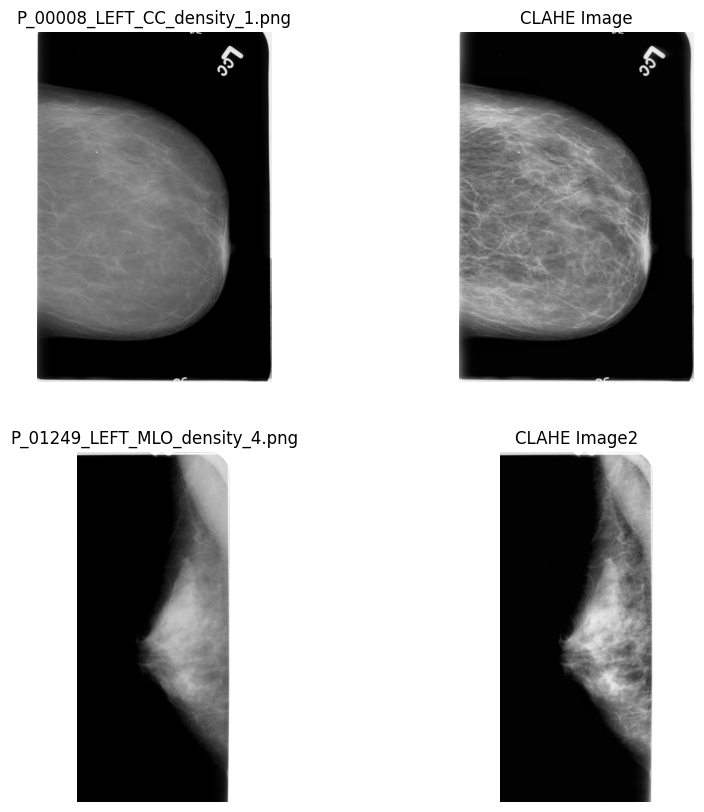

In [9]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

image_clahe = clahe.apply((image * 255).astype(np.uint8))
image2_clahe = clahe.apply((image2 * 255).astype(np.uint8))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(image, cmap="gray")
axes[0, 0].set_title(f"{image_path}")
axes[0, 0].axis("off")

axes[0, 1].imshow(image_clahe, cmap="gray")
axes[0, 1].set_title("CLAHE Image")
axes[0, 1].axis("off")

axes[1, 0].imshow(image2, cmap="gray")
axes[1, 0].set_title(f"{image2_path}")
axes[1, 0].axis("off")

axes[1, 1].imshow(image2_clahe, cmap="gray")
axes[1, 1].set_title("CLAHE Image2")
axes[1, 1].axis("off")

plt.show()

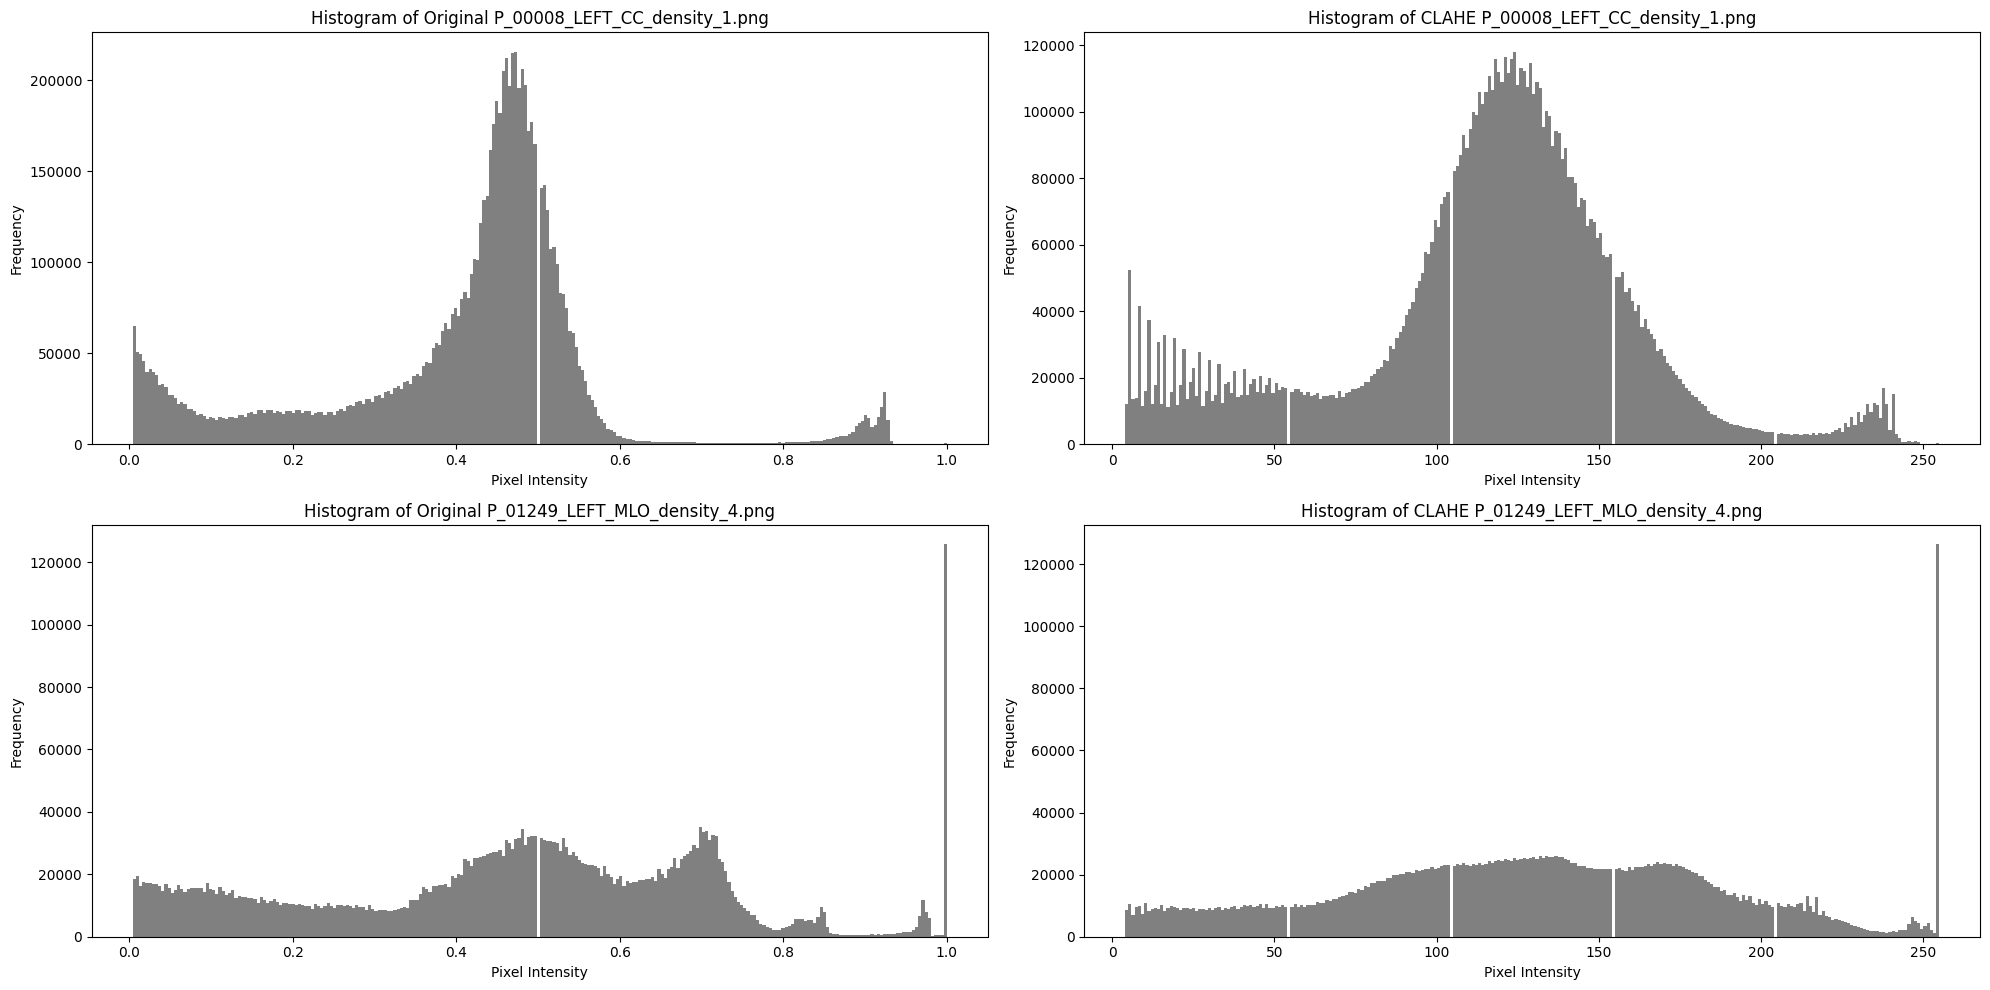

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Histogram of the original image
axes[0, 0].hist(image[image > 0].ravel(), bins=256, color="gray")
axes[0, 0].set_title(f"Histogram of Original {image_path}")
axes[0, 0].set_xlabel("Pixel Intensity")
axes[0, 0].set_ylabel("Frequency")

# Histogram of the CLAHE image
axes[0, 1].hist(image_clahe[image_clahe > 3].ravel(), bins=256, color="gray")
axes[0, 1].set_title(f"Histogram of CLAHE {image_path}")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Frequency")

# Histogram of the second original image
axes[1, 0].hist(image2[image2 > 0].ravel(), bins=256, color="gray")
axes[1, 0].set_title(f"Histogram of Original {image2_path}")
axes[1, 0].set_xlabel("Pixel Intensity")
axes[1, 0].set_ylabel("Frequency")

# Histogram of the second CLAHE image
axes[1, 1].hist(image2_clahe[image2_clahe > 3].ravel(), bins=256, color="gray")
axes[1, 1].set_title(f"Histogram of CLAHE {image2_path}")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Training Data Counts:
  Type  Density  Count
0   CC        1    163
1  MLO        1    182
2   CC        2    429
3  MLO        2    466
4   CC        3    340
5  MLO        3    374
6   CC        4    181
7  MLO        4    218

Test Data Counts:
  Type  Density  Count
0   CC        1     29
1  MLO        1     36
2   CC        2    117
3  MLO        2    138
4   CC        3     93
5  MLO        3    100
6   CC        4     50
7  MLO        4     62


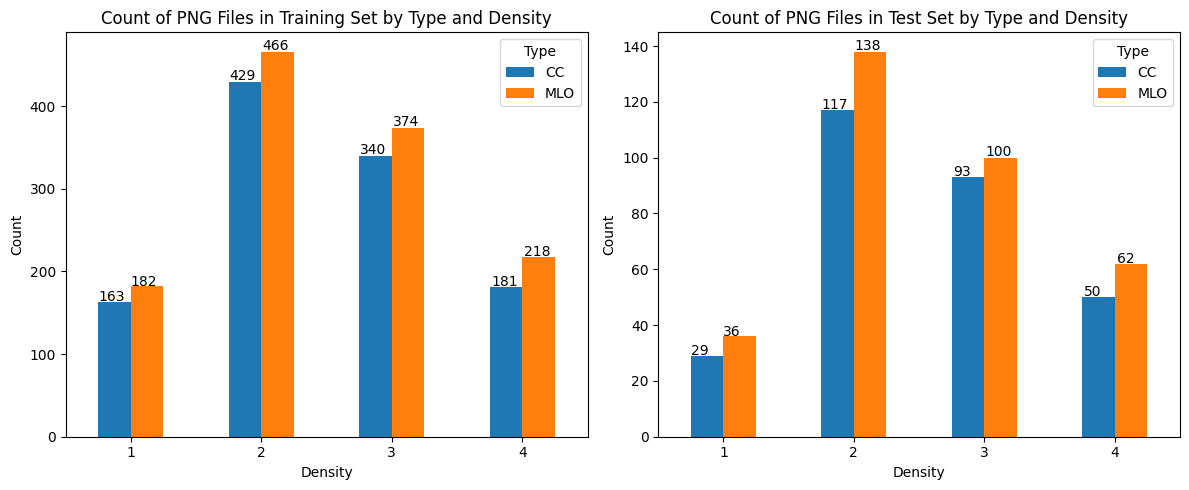

In [11]:
import pandas as pd

data_train = {"Type": [], "Density": [], "Count": []}
data_test = {"Type": [], "Density": [], "Count": []}

for density in range(1, 5):
    for type in ["CC", "MLO"]:
        count_train = sum(
            1
            for filename in train_images_filenames
            if f"{type}_density_{density}" in filename
        )
        data_train["Type"].append(type)
        data_train["Density"].append(density)
        data_train["Count"].append(count_train)

    for type in ["CC", "MLO"]:
        count_test = sum(
            1
            for filename in test_images_filenames
            if f"{type}_density_{density}" in filename
        )
        data_test["Type"].append(type)
        data_test["Density"].append(density)
        data_test["Count"].append(count_test)

df_counts_train = pd.DataFrame(data_train)
df_counts_test = pd.DataFrame(data_test)

print("Training Data Counts:")
print(df_counts_train)
print("\nTest Data Counts:")
print(df_counts_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax_train = axes[0]
df_counts_train.pivot(index="Density", columns="Type", values="Count").plot(
    kind="bar", ax=ax_train
)
ax_train.set_title("Count of PNG Files in Training Set by Type and Density")
ax_train.set_xlabel("Density")
ax_train.set_ylabel("Count")
ax_train.set_xticklabels(ax_train.get_xticklabels(), rotation=0)

for p in ax_train.patches:
    ax_train.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax_test = axes[1]
df_counts_test.pivot(index="Density", columns="Type", values="Count").plot(
    kind="bar", ax=ax_test
)
ax_test.set_title("Count of PNG Files in Test Set by Type and Density")
ax_test.set_xlabel("Density")
ax_test.set_ylabel("Count")
ax_test.set_xticklabels(ax_test.get_xticklabels(), rotation=0)

for p in ax_test.patches:
    ax_test.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.tight_layout()
plt.show()

In [12]:
def count_mask_types(mask_filenames):
    mass_count = sum(1 for filename in mask_filenames if "mass" in filename)
    calc_count = sum(1 for filename in mask_filenames if "calc" in filename)
    return mass_count, calc_count


train_mass_count, train_calc_count = count_mask_types(train_masks_filenames)
test_mass_count, test_calc_count = count_mask_types(test_masks_filenames)

print(f"Number of mass masks in train dataset: {train_mass_count}")
print(f"Number of calc masks in train dataset: {train_calc_count}")
print(f"Number of mass masks in test dataset: {test_mass_count}")
print(f"Number of calc masks in test dataset: {test_calc_count}")

Number of mass masks in train dataset: 1253
Number of calc masks in train dataset: 1544
Number of mass masks in test dataset: 365
Number of calc masks in test dataset: 323


In [13]:
def calculate_average_masks_per_image_by_density(image_filenames, mask_filenames):
    density_mask_counts = {1: [], 2: [], 3: [], 4: []}
    for filename in image_filenames:
        for density in range(1, 5):
            if f"density_{density}" in filename:
                image_id = get_first_4_sections(filename)
                mask_count = sum(
                    1 for mask_filename in mask_filenames if image_id in mask_filename
                )
                density_mask_counts[density].append(mask_count)

    average_masks_per_image_by_density = {
        density: np.mean(counts) for density, counts in density_mask_counts.items()
    }
    return average_masks_per_image_by_density


average_masks_per_image_by_density_train = calculate_average_masks_per_image_by_density(
    train_images_filenames, train_masks_filenames
)
average_masks_per_image_by_density_test = calculate_average_masks_per_image_by_density(
    test_images_filenames, test_masks_filenames
)

for density, avg_count in average_masks_per_image_by_density_train.items():
    print(
        f"Average number of masks (tumors) for density {density} (train): {avg_count:.2f}"
    )
print()
for density, avg_count in average_masks_per_image_by_density_test.items():
    print(
        f"Average number of masks (tumors) for density {density} (test): {avg_count:.2f}"
    )

Average number of masks (tumors) for density 1 (train): 1.31
Average number of masks (tumors) for density 2 (train): 1.17
Average number of masks (tumors) for density 3 (train): 1.20
Average number of masks (tumors) for density 4 (train): 1.10

Average number of masks (tumors) for density 1 (test): 1.14
Average number of masks (tumors) for density 2 (test): 1.11
Average number of masks (tumors) for density 3 (test): 1.12
Average number of masks (tumors) for density 4 (test): 1.01


In [14]:
def get_density_images(density, type, num_images=10):
    density_images = [
        f for f in train_images_filenames if f.endswith(f"{type}_density_{density}.png")
    ]
    if len(density_images) < num_images:
        return density_images
    return density_images[:num_images]


def compute_average_histogram(images):
    histograms = []
    for image_path in images:
        image = plt.imread(os.path.join(train_images_path, image_path))
        hist, _ = np.histogram(image[image > 0].ravel(), bins=256, range=(0, 1))
        histograms.append(hist)
    average_histogram = np.mean(histograms, axis=0)
    return average_histogram

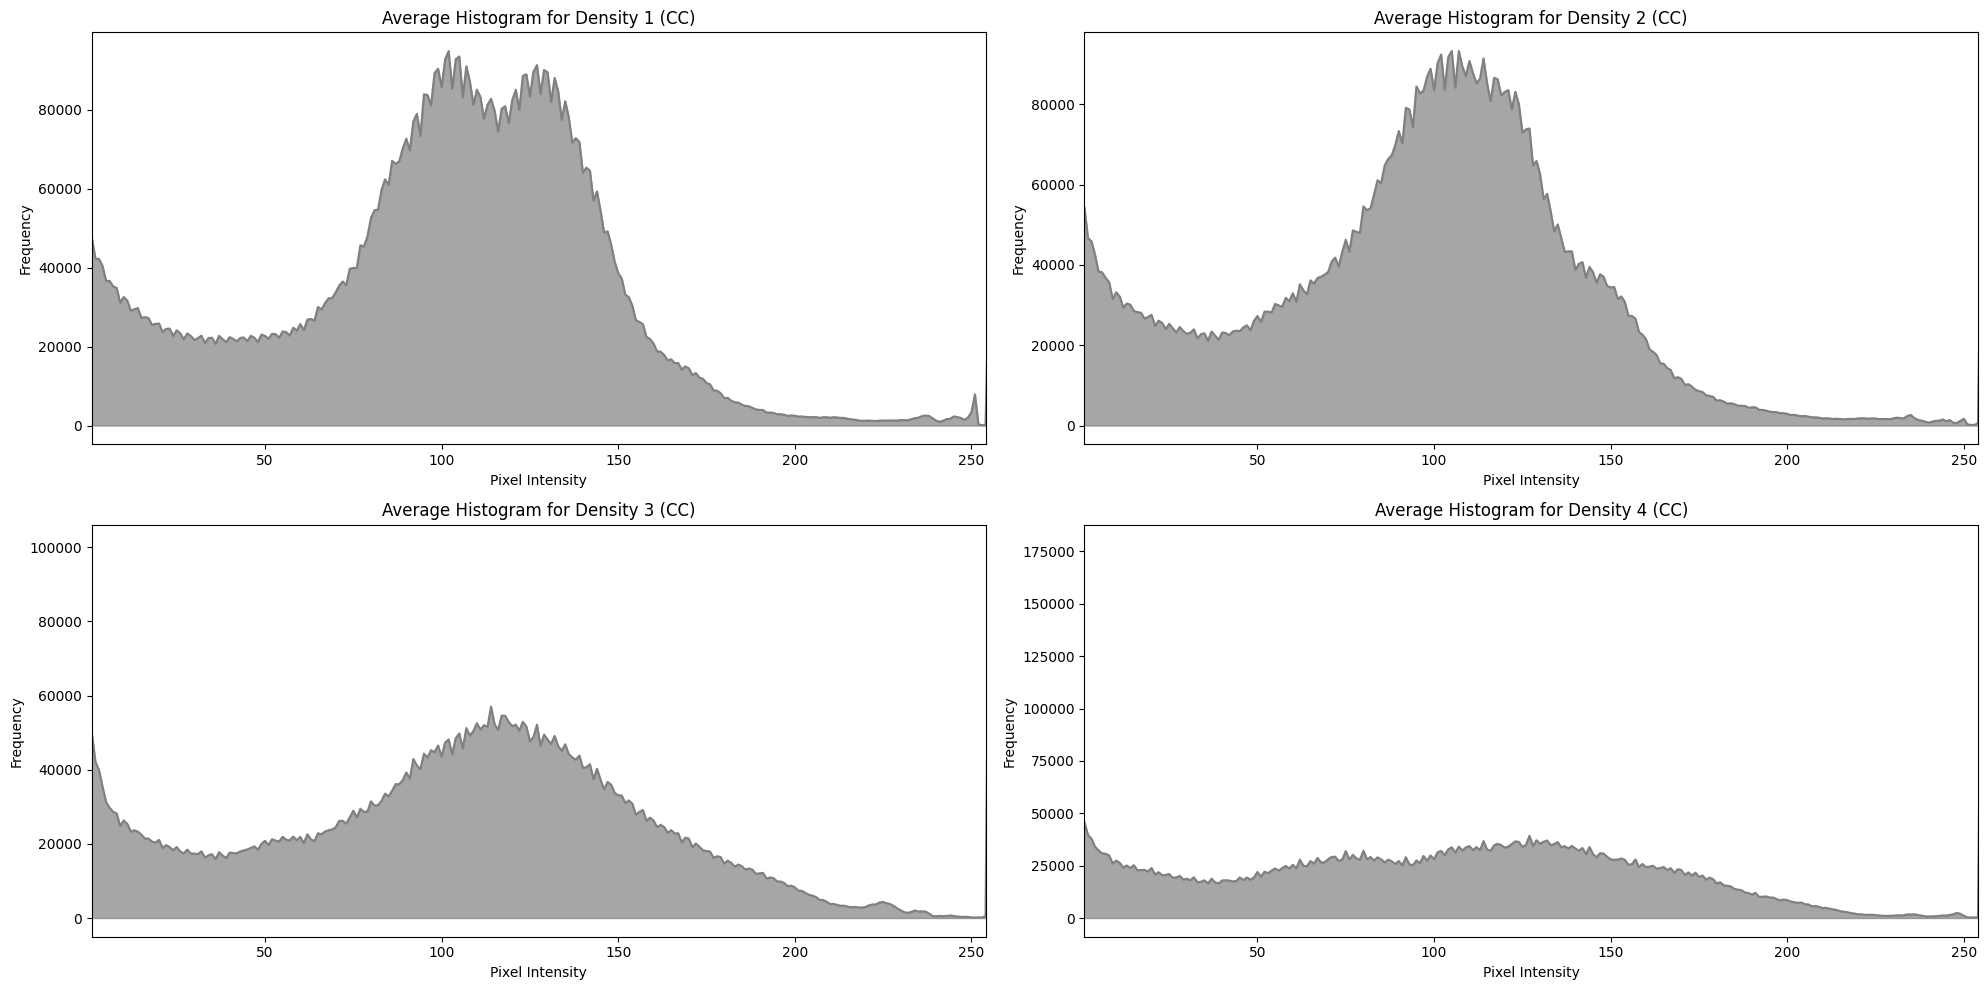

In [15]:
densities = [1, 2, 3, 4]
average_histograms = {}

for density in densities:
    images = get_density_images(density, "CC", 50)
    average_histograms[density] = compute_average_histogram(images)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, density in enumerate(densities):
    ax = axes[i // 2, i % 2]
    ax.plot(average_histograms[density], color="gray")
    ax.set_title(f"Average Histogram for Density {density} (CC)")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.set_xlim([1, 254])
    ax.fill_between(range(0, 256), average_histograms[density], color="gray", alpha=0.7)

plt.tight_layout()
plt.show()

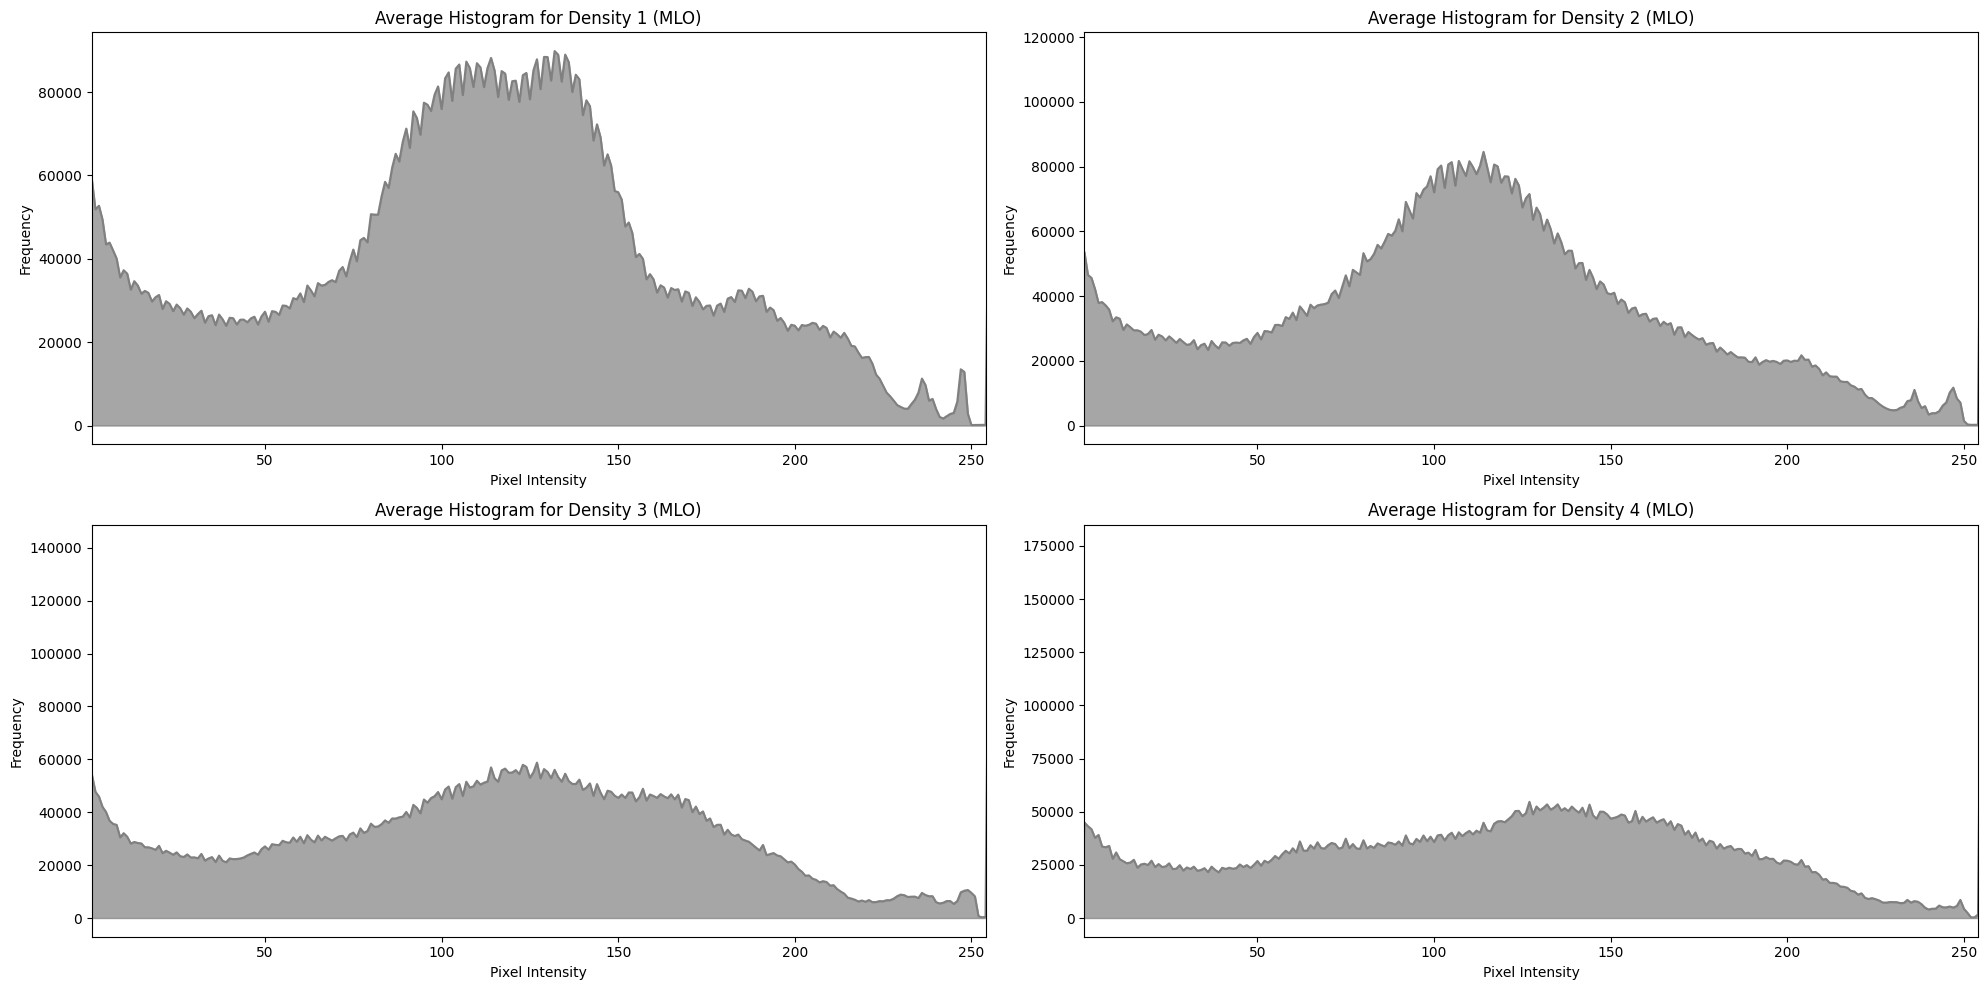

In [16]:
densities = [1, 2, 3, 4]
average_histograms = {}

for density in densities:
    images = get_density_images(density, "MLO", 50)
    average_histograms[density] = compute_average_histogram(images)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, density in enumerate(densities):
    ax = axes[i // 2, i % 2]
    ax.plot(average_histograms[density], color="gray")
    ax.set_title(f"Average Histogram for Density {density} (MLO)")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.set_xlim([1, 254])
    ax.fill_between(range(0, 256), average_histograms[density], color="gray", alpha=0.7)

plt.tight_layout()
plt.show()

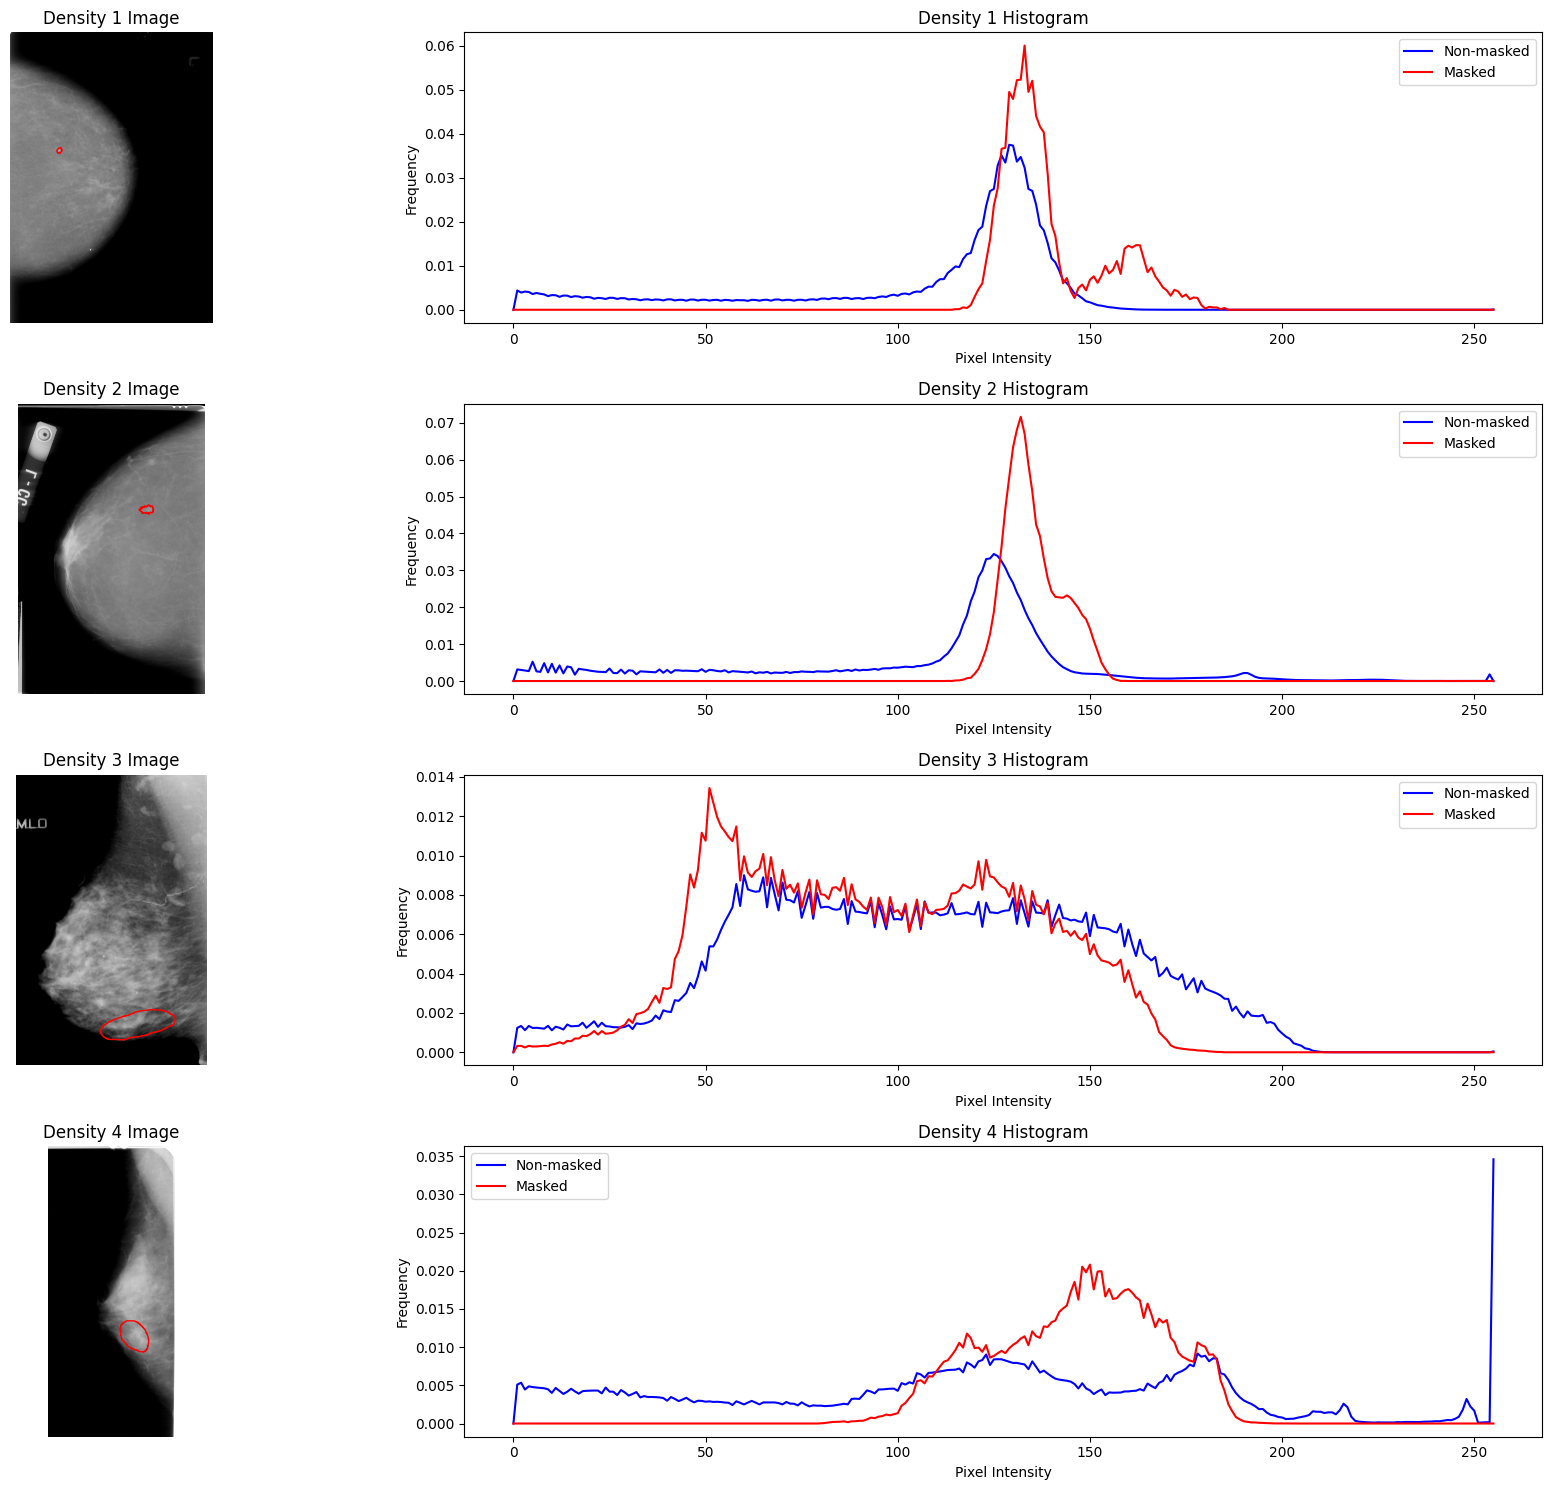

In [17]:
def get_image_and_masks(density, num_images=1):
    images = [f for f in train_images_filenames if f"density_{density}" in f][
        :num_images
    ]
    image_and_masks = ()
    for image_path in images:
        image_id = get_first_4_sections(image_path)
        masks = [
            os.path.join(train_masks_path, f)
            for f in train_masks_filenames
            if image_id in f
        ]
        image_and_masks = (image_path, masks)
    return image_and_masks


def compute_histograms(image, masks):
    mask_combined = np.zeros_like(image, dtype=bool)
    for mask_path in masks:
        mask = plt.imread(mask_path)
        mask_combined = np.logical_or(mask_combined, mask > 0)

    non_masked_hist, _ = np.histogram(
        image[~mask_combined & (image > 0)].ravel(), bins=256, range=(0, 1)
    )
    masked_hist, _ = np.histogram(
        image[mask_combined & (image > 0)].ravel(), bins=256, range=(0, 1)
    )

    non_masked_hist = non_masked_hist / non_masked_hist.sum()
    masked_hist = masked_hist / masked_hist.sum()

    return non_masked_hist, masked_hist


density_1_images_and_masks = get_image_and_masks(1)
density_2_images_and_masks = get_image_and_masks(2)
density_3_images_and_masks = get_image_and_masks(3)
density_4_images_and_masks = get_image_and_masks(4)
densities = [1, 2, 3, 4]
images_and_masks = [
    density_1_images_and_masks,
    density_2_images_and_masks,
    density_3_images_and_masks,
    density_4_images_and_masks,
]


fig, axes = plt.subplots(4, 2, figsize=(20, 15))

for i, (density, (image_path, masks)) in enumerate(zip(densities, images_and_masks)):
    image = plt.imread(os.path.join(train_images_path, image_path))
    non_masked_hist, masked_hist = compute_histograms(image, masks)

    axes[i, 0].imshow(image, cmap="gray")
    axes[i, 0].set_title(f"Density {density} Image")
    axes[i, 0].axis("off")

    for mask_path in masks:
        mask = plt.imread(mask_path)
        contours = measure.find_contours(mask, 0.5)
        for contour in contours:
            axes[i, 0].plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")

    axes[i, 1].plot(non_masked_hist, color="blue", label="Non-masked")
    axes[i, 1].plot(masked_hist, color="red", label="Masked")
    axes[i, 1].set_title(f"Density {density} Histogram")
    axes[i, 1].set_xlabel("Pixel Intensity")
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

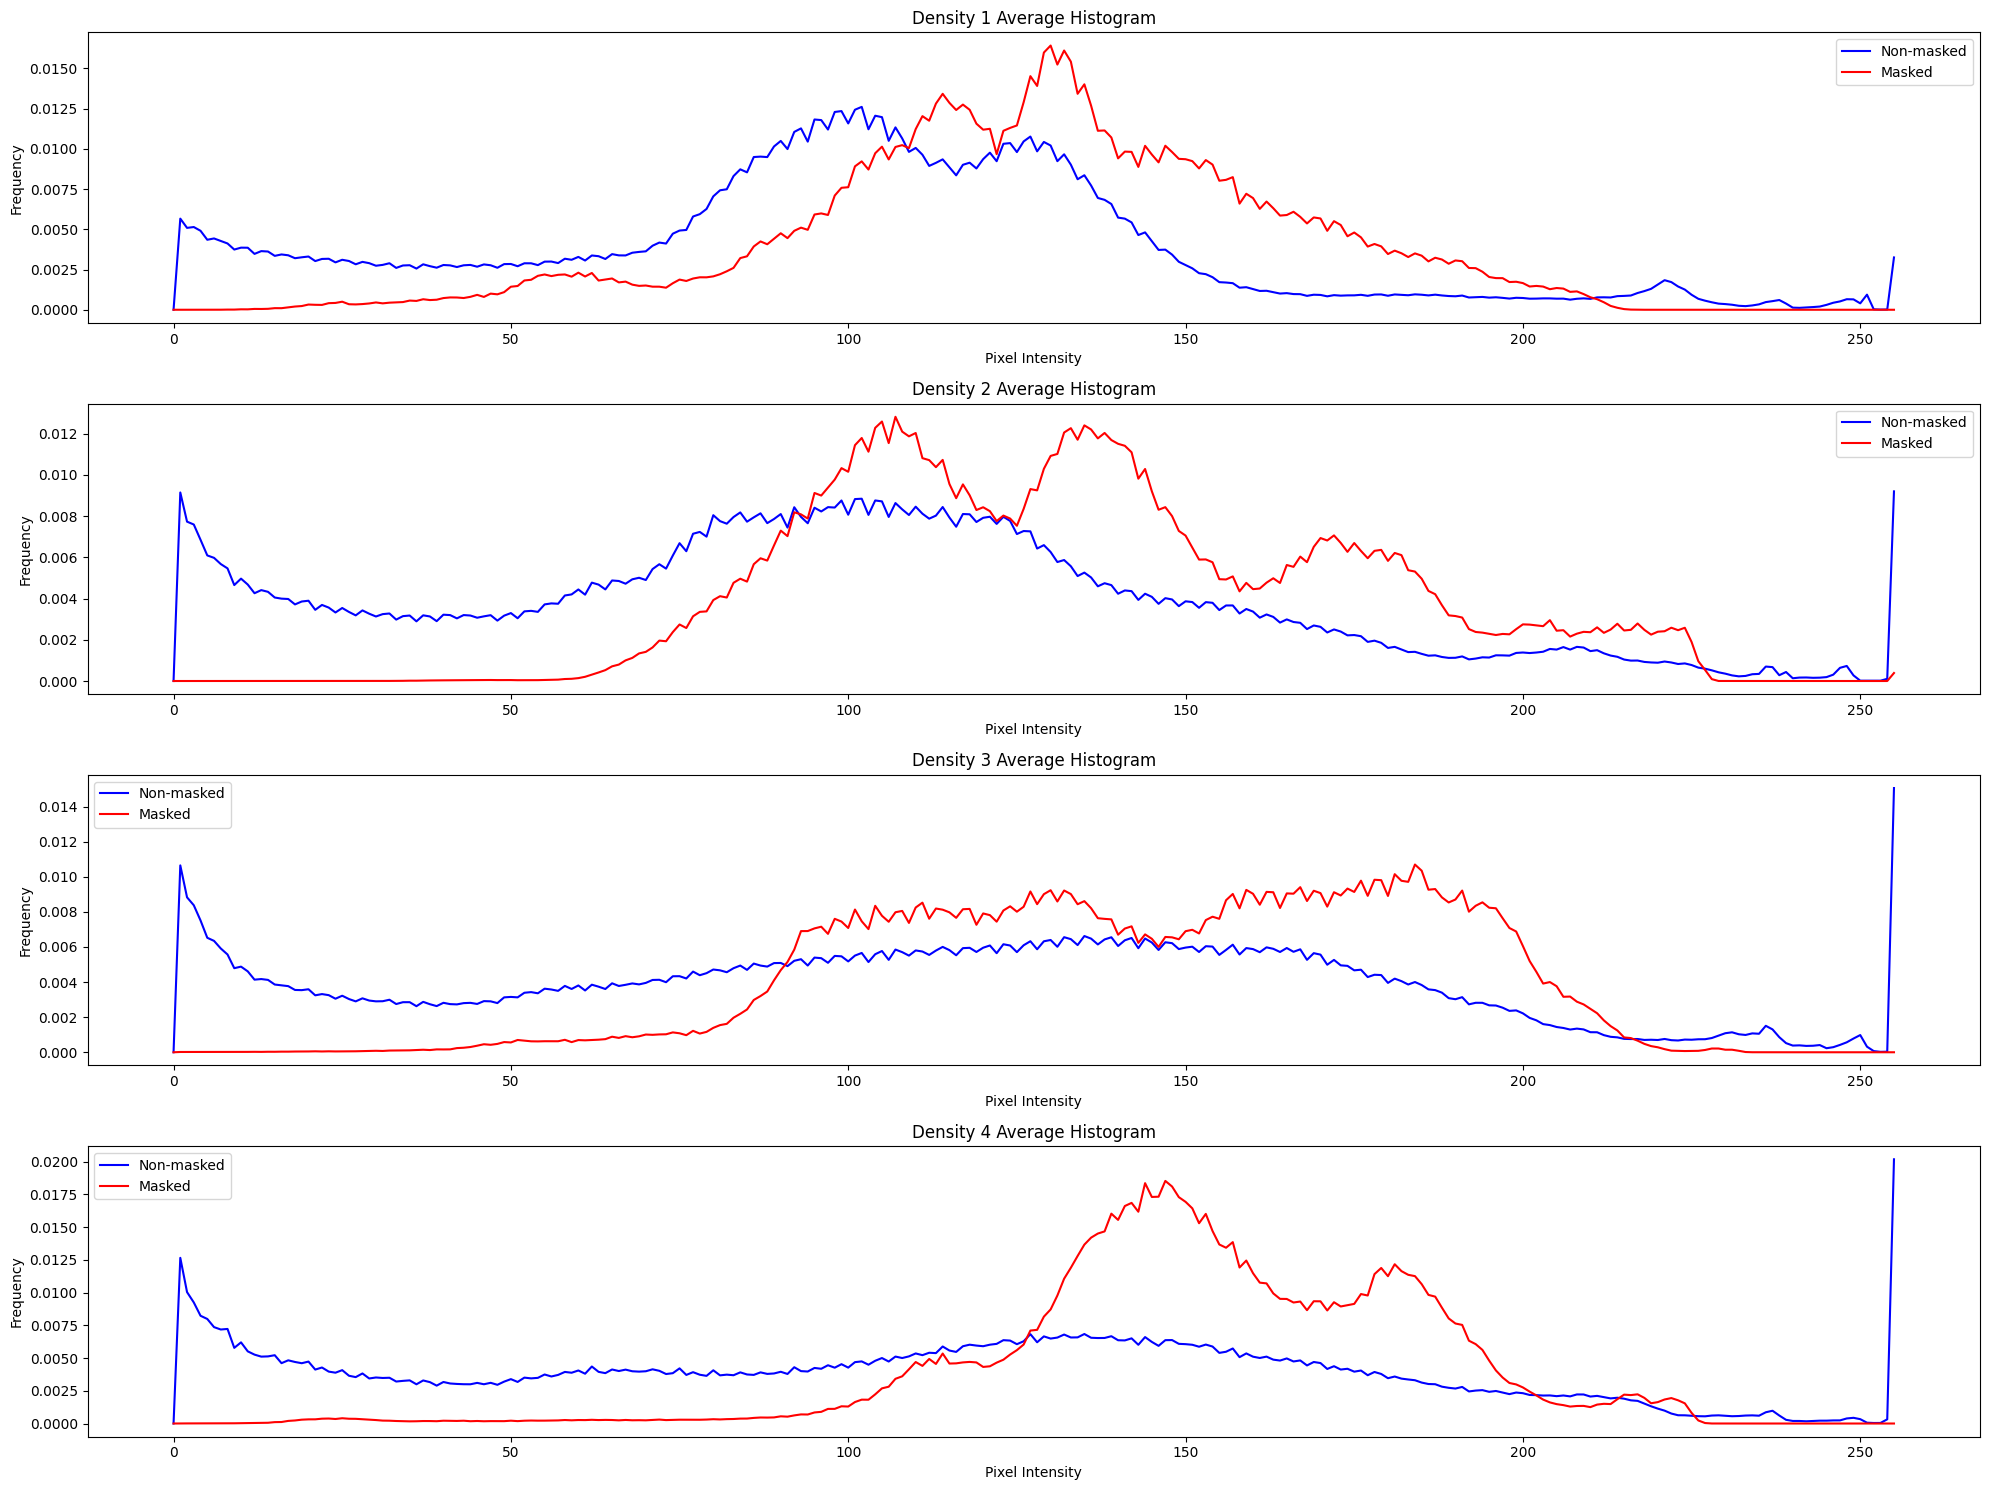

In [18]:
def get_image_and_masks(density, num_images=20):
    images = [f for f in train_images_filenames if f"density_{density}" in f][
        :num_images
    ]
    image_and_masks = []
    for image_path in images:
        image_id = get_first_4_sections(image_path)
        masks = [
            os.path.join(train_masks_path, f)
            for f in train_masks_filenames
            if image_id in f
        ]
        image_and_masks.append((image_path, masks))
    return image_and_masks


def compute_average_histograms(images_and_masks):
    non_masked_histograms = []
    masked_histograms = []
    for image_path, masks in images_and_masks:
        image = plt.imread(os.path.join(train_images_path, image_path))
        non_masked_hist, masked_hist = compute_histograms(image, masks)
        non_masked_histograms.append(non_masked_hist)
        masked_histograms.append(masked_hist)

    average_non_masked_hist = np.mean(non_masked_histograms, axis=0)
    average_masked_hist = np.mean(masked_histograms, axis=0)

    return average_non_masked_hist, average_masked_hist


density_1_images_and_masks = get_image_and_masks(1)
density_2_images_and_masks = get_image_and_masks(2)
density_3_images_and_masks = get_image_and_masks(3)
density_4_images_and_masks = get_image_and_masks(4)
densities = [1, 2, 3, 4]
images_and_masks = [
    density_1_images_and_masks,
    density_2_images_and_masks,
    density_3_images_and_masks,
    density_4_images_and_masks,
]

fig, axes = plt.subplots(4, 1, figsize=(20, 15))

for i, (density, images_and_masks) in enumerate(zip(densities, images_and_masks)):
    average_non_masked_hist, average_masked_hist = compute_average_histograms(
        images_and_masks
    )
    axes[i].plot(average_non_masked_hist, color="blue", label="Non-masked")
    axes[i].plot(average_masked_hist, color="red", label="Masked")
    axes[i].set_title(f"Density {density} Average Histogram")
    axes[i].set_xlabel("Pixel Intensity")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()